##   Made By Gafur Abdirakhman 180107121, Yerkebulan Gylymmedden 180107262, Nurbergen Akbergenov 180107286

#   Import necessary libraries

In [1]:
pip install pyspark

     |████████████████████████████████| 212.3MB 80kB/s 
     |████████████████████████████████| 204kB 17.8MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=d34863ca73d0e4f13570b19282889244b5e20288de99ff37e7efc3432c435b89
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [2]:
import numpy as np

from matplotlib import pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, lit
from pyspark.sql.types import DoubleType
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.ml import evaluation

#   Basic info about dataset

## Read dataset

In [3]:
spark = SparkSession.builder.appName("local").getOrCreate()
df = spark.read.option("header", True).csv("/kidney_disease.csv") 

In [4]:
df.show()

+---+----+-----+-----+----+----+--------+--------+----------+----------+-----+-----+----+-----+----+----+----+-----+----+---+---+---+-----+---+---+--------------+
| id| age|   bp|   sg|  al|  su|     rbc|      pc|       pcc|        ba|  bgr|   bu|  sc|  sod| pot|hemo| pcv|   wc|  rc|htn| dm|cad|appet| pe|ane|classification|
+---+----+-----+-----+----+----+--------+--------+----------+----------+-----+-----+----+-----+----+----+----+-----+----+---+---+---+-----+---+---+--------------+
|  0|48.0| 80.0| 1.02| 1.0| 0.0|    null|  normal|notpresent|notpresent|121.0| 36.0| 1.2| null|null|15.4|  44| 7800| 5.2|yes|yes| no| good| no| no|           ckd|
|  1| 7.0| 50.0| 1.02| 4.0| 0.0|    null|  normal|notpresent|notpresent| null| 18.0| 0.8| null|null|11.3|  38| 6000|null| no| no| no| good| no| no|           ckd|
|  2|62.0| 80.0| 1.01| 2.0| 3.0|  normal|  normal|notpresent|notpresent|423.0| 53.0| 1.8| null|null| 9.6|  31| 7500|null| no|yes| no| poor| no|yes|           ckd|
|  3|48.0| 70.0|1.005|

## Brief information

In [5]:
df.count() #Number of rows/length of dataset

400

In [6]:
df.printSchema() #Information about type of columns

root
 |-- id: string (nullable = true)
 |-- age: string (nullable = true)
 |-- bp: string (nullable = true)
 |-- sg: string (nullable = true)
 |-- al: string (nullable = true)
 |-- su: string (nullable = true)
 |-- rbc: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- pcc: string (nullable = true)
 |-- ba: string (nullable = true)
 |-- bgr: string (nullable = true)
 |-- bu: string (nullable = true)
 |-- sc: string (nullable = true)
 |-- sod: string (nullable = true)
 |-- pot: string (nullable = true)
 |-- hemo: string (nullable = true)
 |-- pcv: string (nullable = true)
 |-- wc: string (nullable = true)
 |-- rc: string (nullable = true)
 |-- htn: string (nullable = true)
 |-- dm: string (nullable = true)
 |-- cad: string (nullable = true)
 |-- appet: string (nullable = true)
 |-- pe: string (nullable = true)
 |-- ane: string (nullable = true)
 |-- classification: string (nullable = true)



In [7]:
for column in df.columns:
     if column == 'id':
          continue
     df.describe([column]).show() #statistical information

+-------+-----------------+
|summary|              age|
+-------+-----------------+
|  count|              391|
|   mean|51.48337595907928|
| stddev|17.16971408926224|
|    min|             11.0|
|    max|             90.0|
+-------+-----------------+

+-------+-----------------+
|summary|               bp|
+-------+-----------------+
|  count|              388|
|   mean|76.46907216494846|
| stddev|13.68363749352527|
|    min|            100.0|
|    max|             90.0|
+-------+-----------------+

+-------+--------------------+
|summary|                  sg|
+-------+--------------------+
|  count|                 353|
|   mean|  1.0174079320113256|
| stddev|0.005716616974376756|
|    min|               1.005|
|    max|               1.025|
+-------+--------------------+

+-------+------------------+
|summary|                al|
+-------+------------------+
|  count|               354|
|   mean|1.0169491525423728|
| stddev|1.3526789127628445|
|    min|               0.0|
|    max|  

## Data clean

In [8]:
#check unique values for classification  
#and to make sure that in future we will be able to use Machine learning algorithms 
df.select('classification').distinct().collect()
#as you can see it gives 3 values which are both of them is equivalent, but with /t

[Row(classification='notckd'),
 Row(classification='ckd'),
 Row(classification='ckd\t')]

In [9]:
 df.filter(df['classification']=="ckd\t").show()
#so, we are going to replace those 2 rows to ckd's rows.

+---+----+----+----+----+----+------+--------+----------+----------+-----+----+---+-----+---+----+----+----+----+---+---+---+-----+---+---+--------------+
| id| age|  bp|  sg|  al|  su|   rbc|      pc|       pcc|        ba|  bgr|  bu| sc|  sod|pot|hemo| pcv|  wc|  rc|htn| dm|cad|appet| pe|ane|classification|
+---+----+----+----+----+----+------+--------+----------+----------+-----+----+---+-----+---+----+----+----+----+---+---+---+-----+---+---+--------------+
| 37|72.0|80.0|null|null|null|  null|    null|notpresent|notpresent|137.0|65.0|3.4|141.0|4.7| 9.7|  28|6900| 2.5|yes|yes| no| poor| no|yes|          ckd	|
|230|65.0|60.0|1.01| 2.0| 0.0|normal|abnormal|   present|notpresent|192.0|17.0|1.7|130.0|4.3|null|null|9500|null|yes|yes| no| poor| no| no|          ckd	|
+---+----+----+----+----+----+------+--------+----------+----------+-----+----+---+-----+---+----+----+----+----+---+---+---+-----+---+---+--------------+



In [10]:
#let's do it with additional libraries such as when and lit which are helps us with replacing values
df = df.withColumn('classification', when(df['classification']=='ckd\t', 
lit("ckd")).otherwise(df['classification']))

In [11]:
#we alrealy replaced it, so, let's see
df.filter(df['classification']=="ckd\t").show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+
| id|age| bp| sg| al| su|rbc| pc|pcc| ba|bgr| bu| sc|sod|pot|hemo|pcv| wc| rc|htn| dm|cad|appet| pe|ane|classification|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+



In [12]:
#so, we have only 2 values in classification column 
df.select('classification').distinct().collect()

[Row(classification='notckd'), Row(classification='ckd')]

In [13]:
#drop all rows with nan
df = df.na.drop()

In [14]:
#let's check and count data which are missing values for each columns
for column in df.columns:
    print(column, "\n", "Missing values: ", df.filter(df[column].isNull()).count())

id 
 Missing values:  0
age 
 Missing values:  0
bp 
 Missing values:  0
sg 
 Missing values:  0
al 
 Missing values:  0
su 
 Missing values:  0
rbc 
 Missing values:  0
pc 
 Missing values:  0
pcc 
 Missing values:  0
ba 
 Missing values:  0
bgr 
 Missing values:  0
bu 
 Missing values:  0
sc 
 Missing values:  0
sod 
 Missing values:  0
pot 
 Missing values:  0
hemo 
 Missing values:  0
pcv 
 Missing values:  0
wc 
 Missing values:  0
rc 
 Missing values:  0
htn 
 Missing values:  0
dm 
 Missing values:  0
cad 
 Missing values:  0
appet 
 Missing values:  0
pe 
 Missing values:  0
ane 
 Missing values:  0
classification 
 Missing values:  0


## labels comparing 

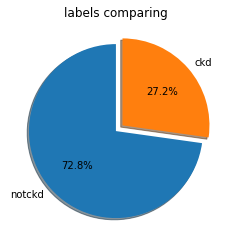

In [15]:
a = df.select('classification').collect()
notckd = 0
ckd = 0
for i in a:
    if i[0] == 'ckd':
        ckd += 1
    else:
        notckd += 1
labels = 'notckd', 'ckd'
sizes = [notckd * 100 / (notckd + ckd), ckd * 100 / (notckd + ckd)]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('labels comparing')
plt.show() #Below, we can see that our label of the cleaned dataset is unbalanced, so accuracy metrics will be useless to estimate the model in the future.

#  Implementing Machine Learning algorithms

In [16]:
data = df.select('age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'classification') #select columns which can be converted from string to double

In [17]:
for column in data.columns:
    if column == 'classification':
        break
    data = data.withColumn(column, data[column].cast(DoubleType())) #change type from string to double

In [18]:
colors = data.select('classification').collect()
c = ['blue' if str(i[0]) == 'notckd' else 'red' for i in colors] #Make list of color to makr classification plot

In [19]:
data.show()

+----+-----+-----+---+---+-----+-----+----+-----+----+----+----+-------+---+--------------+
| age|   bp|   sg| al| su|  bgr|   bu|  sc|  sod| pot|hemo| pcv|     wc| rc|classification|
+----+-----+-----+---+---+-----+-----+----+-----+----+----+----+-------+---+--------------+
|48.0| 70.0|1.005|4.0|0.0|117.0| 56.0| 3.8|111.0| 2.5|11.2|32.0| 6700.0|3.9|           ckd|
|53.0| 90.0| 1.02|2.0|0.0| 70.0|107.0| 7.2|114.0| 3.7| 9.5|29.0|12100.0|3.7|           ckd|
|63.0| 70.0| 1.01|3.0|0.0|380.0| 60.0| 2.7|131.0| 4.2|10.8|32.0| 4500.0|3.8|           ckd|
|68.0| 80.0| 1.01|3.0|2.0|157.0| 90.0| 4.1|130.0| 6.4| 5.6|16.0|11000.0|2.6|           ckd|
|61.0| 80.0|1.015|2.0|0.0|173.0|148.0| 3.9|135.0| 5.2| 7.7|24.0| 9200.0|3.2|           ckd|
|48.0| 80.0|1.025|4.0|0.0| 95.0|163.0| 7.7|136.0| 3.8| 9.8|32.0| 6900.0|3.4|           ckd|
|69.0| 70.0| 1.01|3.0|4.0|264.0| 87.0| 2.7|130.0| 4.0|12.5|37.0| 9600.0|4.1|           ckd|
|73.0| 70.0|1.005|0.0|0.0| 70.0| 32.0| 0.9|125.0| 4.0|10.0|29.0|18900.0|3.5|    

In [20]:
assembler = feature.VectorAssembler(inputCols=['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc'],outputCol="features") #collect all columns to one feature
data = assembler.transform(data)

##  StandardScaler 

In [21]:
scaler = feature.StandardScaler(inputCol="features", outputCol="SSout",
                        withStd=True, withMean=True)
scalerModel = scaler.fit(data)
scaledData = scalerModel.transform(data)

## PCA implementing

In [22]:
pca = feature.PCA(k=2, inputCol="SSout", outputCol="pcaFeatures")
model = pca.fit(scaledData)

result = model.transform(scaledData).select("pcaFeatures", "classification")

In [23]:
X = []
for i in result.select("pcaFeatures").collect():
    X.append([i[0][0], i[0][1]])
X = np.array(X) #Convert updated features from pyspark to numpy array

##  Data visualization

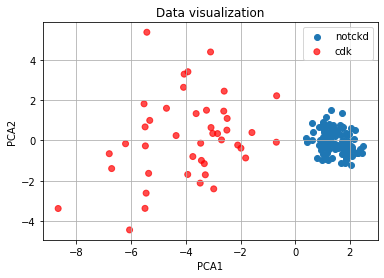

In [24]:
x_red = []
red = []
x_blue = []
blue = []
for i in range(len(X)):
    if c[i] == 'red':
        x_red.append(X[i])
        red.append(c[i])
    else:
        x_blue.append(X[i])
        blue.append(c[i])
x_red = np.array(x_red)
red = np.array(red)
x_blue = np.array(x_blue)
blue = np.array(blue)
plt.scatter(x_blue[:,0], x_blue[:,1], label = 'notckd')
plt.scatter(x_red[:,0], x_red[:,1], c=red, alpha=0.7, label = 'cdk')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid()
plt.legend()
plt.title('Data visualization')
plt.show()

In [25]:
result.show()

+--------------------+--------------+
|         pcaFeatures|classification|
+--------------------+--------------+
|[-3.4298082810042...|           ckd|
|[-3.4754560761380...|           ckd|
|[-3.2446867740835...|           ckd|
|[-5.4900484862099...|           ckd|
|[-3.7443007061682...|           ckd|
|[-2.9799547646873...|           ckd|
|[-3.9236059743282...|           ckd|
|[-2.4888323261282...|           ckd|
|[-2.6950436305699...|           ckd|
|[-2.4989563640813...|           ckd|
|[-3.2873235172557...|           ckd|
|[-3.9313672617946...|           ckd|
|[-5.4937342909021...|           ckd|
|[-2.5973258215255...|           ckd|
|[-0.6788080196123...|           ckd|
|[-3.0149307317597...|           ckd|
|[-4.7085724777884...|           ckd|
|[-2.8411973972218...|           ckd|
|[-6.7142534874477...|           ckd|
|[-5.3617086947228...|           ckd|
+--------------------+--------------+
only showing top 20 rows



##  Implementing StringIndexer

In [26]:
indexer = feature.StringIndexer(inputCol="classification", outputCol="categoryIndex")
indexed = indexer.fit(result).transform(result)
indexed.show() #Replce words with numbers

+--------------------+--------------+-------------+
|         pcaFeatures|classification|categoryIndex|
+--------------------+--------------+-------------+
|[-3.4298082810042...|           ckd|          1.0|
|[-3.4754560761380...|           ckd|          1.0|
|[-3.2446867740835...|           ckd|          1.0|
|[-5.4900484862099...|           ckd|          1.0|
|[-3.7443007061682...|           ckd|          1.0|
|[-2.9799547646873...|           ckd|          1.0|
|[-3.9236059743282...|           ckd|          1.0|
|[-2.4888323261282...|           ckd|          1.0|
|[-2.6950436305699...|           ckd|          1.0|
|[-2.4989563640813...|           ckd|          1.0|
|[-3.2873235172557...|           ckd|          1.0|
|[-3.9313672617946...|           ckd|          1.0|
|[-5.4937342909021...|           ckd|          1.0|
|[-2.5973258215255...|           ckd|          1.0|
|[-0.6788080196123...|           ckd|          1.0|
|[-3.0149307317597...|           ckd|          1.0|
|[-4.7085724

In [27]:
#we split data to train(90%) and test(10%) 
train, test = indexed.select("pcaFeatures", "categoryIndex").randomSplit([0.9, 0.1], seed=1)

## Implementing LG, DT, SVM and train them

In [28]:
#use three classification algorithms
lr = classification.LogisticRegression(featuresCol = 'pcaFeatures', labelCol = 'categoryIndex', predictionCol="predictions")
lrModel = lr.fit(train)
dt = classification.DecisionTreeClassifier(featuresCol = 'pcaFeatures', labelCol = 'categoryIndex', predictionCol="predictions")
dtModel = dt.fit(train)

svm = classification.LinearSVC(featuresCol = 'pcaFeatures', labelCol = 'categoryIndex', predictionCol="predictions")
svmModel = svm.fit(train)

# Implementing Metrics

## ROC, Precision, Recall

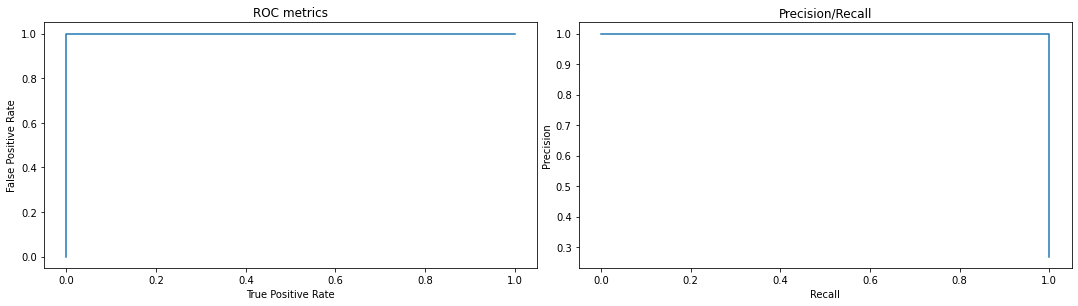

Training set areaUnderROC: 1.0


In [29]:
#add some metrics
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
pr = trainingSummary.pr.toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
fig.set_figheight(4)
fig.tight_layout()
ax1.plot(roc['FPR'],roc['TPR'])
ax1.set_title('ROC metrics')
ax1.set(xlabel = 'True Positive Rate', ylabel = 'False Positive Rate')

ax2.plot(pr['recall'],pr['precision'])
ax2.set_title('Precision/Recall')
ax2.set(xlabel = 'Recall', ylabel = 'Precision')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Make predictions

In [30]:
lr_predictions = lrModel.transform(test)

dt_predictions = dtModel.transform(test)

svm_predictions = svmModel.transform(test)

## Accuracy

In [31]:
evaluator = evaluation.MulticlassClassificationEvaluator(
    labelCol="categoryIndex", predictionCol="predictions", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions)
print('Logistic Regression model accuracy = ' + str(accuracy*100) + '%')
accuracy = evaluator.evaluate(dt_predictions)
print('Decision Tree model accuracy = ' + str(accuracy*100) + '%')
accuracy = evaluator.evaluate(svm_predictions)
print('Support Vector Machine model accuracy = ' + str(accuracy*100) + '%')

Logistic Regression model accuracy = 100.0%
Decision Tree model accuracy = 92.3076923076923%
Support Vector Machine model accuracy = 100.0%
